In [78]:
# Import libraries.
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import timedelta 
import matplotlib.pyplot as plt

In [2]:
# Read in 'takehome_user_engagement.csv' as DataFrame.
df = pd.read_csv('takehome_user_engagement.csv')
df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [32]:
# Read in 'takehome_users.csv' as DataFrame.
df2 = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [33]:
# Label 'adopted users' as users who have logged in on three seperate days in a seven day period.
df = df.sort_values('time_stamp').reset_index(drop=True)

df.time_stamp = pd.to_datetime(df.time_stamp)
df.time_stamp = df.time_stamp.dt.normalize()

login_df = df.groupby('time_stamp')['user_id'].apply(list)

t_delta = timedelta(days = 6)

min_date = login_df.index.min()
max_date = min_date + t_delta

# Gather all users that logged in durng a given seven day period.
user_list = []
while len(login_df) > 0:
    min_date = login_df.index.min()
    max_date = min_date + t_delta
    res_list = [y for x in login_df[:max_date].values for y in x]
    user_list.append(res_list)
    login_df = login_df.drop(login_df.loc[:max_date].index)
    
# Gather the user ID's that occured 3 or more times.
adopted_ids = []
for list_ in user_list:
    sample = pd.Series(list_).value_counts()
    for ind in sample.index:
        if sample.loc[ind] > 2 and ind not in adopted_ids:
                adopted_ids.append(ind)
                
df2['adopted_user'] = [True if ID in adopted_ids else False for ID in df2.object_id]
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [34]:
# How many adopt users are there?
df2.adopted_user.value_counts()

False    10555
True      1445
Name: adopted_user, dtype: int64

There seems to be significantly more non-adopters than adopted.  For the sake of the predictions, I'll take a sample so they match.

In [35]:
# Convert values of 'creation_time' column into datetime objects.
df2.creation_time = pd.to_datetime(df2.creation_time)

In [36]:
# Encode non-numeric data into integers.
from sklearn import preprocessing

LE = preprocessing.LabelEncoder()

encoded_dic={}

for column in df2.columns:
    if df2[column].dtype != 'float64' and df2[column].dtype != 'int64':
        encoded = LE.fit_transform(df2[column].values)
        encoded_dic[column] = encoded
        
new_df = pd.DataFrame(encoded_dic)

df2_ = df2.drop(columns=new_df.columns).copy()

encoded_df = pd.concat([new_df, df2_], axis=1)
encoded_df = encoded_df[df2.columns]

In [37]:
# Drop 'name' and 'email' columns.
encoded_df = encoded_df.drop(columns=['name', 'email'])

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,10807,0,1.398139e+09,1,0,11,10803.0,0
1,2,7647,1,1.396238e+09,0,0,1,316.0,0
2,3,3939,1,1.363735e+09,0,0,94,1525.0,0
3,4,4845,0,1.369210e+09,0,0,1,5151.0,0
4,5,3018,0,1.358850e+09,0,0,193,5240.0,0


In [38]:
# Determine if / which columns have missing data.
null_data_columns = []

for column in encoded_df.columns.values:
    print(column + ' : ' + str(encoded_df[column].isna().any()))
    if encoded_df[column].isna().any() == True:
        null_data_columns.append(column)

object_id : False
creation_time : False
creation_source : False
last_session_creation_time : True
opted_in_to_mailing_list : False
enabled_for_marketing_drip : False
org_id : False
invited_by_user_id : True
adopted_user : False


In [39]:
# Determine how much useful data there is in each column with mising data.
for column in null_data_columns:
    print(column + ' : ' + str(encoded_df[column].value_counts().sum()))

last_session_creation_time : 8823
invited_by_user_id : 6417


These two columns have a significant amount of null data.  I'll be dropping **last_session_creation_time** since that's a bit of a giveaway as to whether or not the users remain active, but I will fill in the NaN within **invited_by_user_id** with zero's.

In [40]:
# Fill in all 'NaN' in 'invited_by_user_id' column and drop 'last_session_creation_time', 'creation_time' and 'object_id'.
encoded_df['invited_by_user_id'] = encoded_df['invited_by_user_id'].fillna(0)
encoded_df = encoded_df.drop(columns=['last_session_creation_time', 'creation_time', 'object_id'])

In [42]:
# Reduce sample of 'False' adopted users to match total or 'True'.
encoded_df_true = encoded_df[encoded_df.adopted_user == True]
encoded_df_false = encoded_df[encoded_df.adopted_user == False].sample(n=len(encoded_df[encoded_df.adopted_user == True]))
encoded_df = pd.concat([encoded_df_true, encoded_df_false], axis=0)

In [66]:
# Perform Random Forest Classifier.
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Split training / test sets.
X = encoded_df.drop(columns=['adopted_user'])
y = encoded_df['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0) 

rfc = RandomForestClassifier(n_estimators=1000, random_state=0).fit(X_train, y_train)

y_pred = rfc.predict(X_test)

# Print classification results.
rfc_class_report = classification_report(y_test,y_pred)
print(rfc_class_report)
print('Accuracy Score: {}'.format(round(accuracy_score(y_test, y_pred), 2)))
print('')
print('Feature Importance:')
print(pd.Series(rfc.feature_importances_,index=X.columns).sort_values(ascending=False))

              precision    recall  f1-score   support

           0       0.51      0.54      0.52       347
           1       0.55      0.52      0.54       376

    accuracy                           0.53       723
   macro avg       0.53      0.53      0.53       723
weighted avg       0.53      0.53      0.53       723

Accuracy Score: 0.53

Feature Importance:
org_id                        0.617329
invited_by_user_id            0.298529
creation_source               0.048725
opted_in_to_mailing_list      0.018250
enabled_for_marketing_drip    0.017167
dtype: float64


Not the best accuracy, but to be expected with the limited features available.  According to the Random Forest classifier, **org_id** is the most significant feature.

In [64]:
final_uncoded_df = final_df.copy()

dic = {}

for column in encoded_df.columns:
    dic[column] = {}
    for i in encoded_df.index.values:
        dic[column].update({encoded_df[column][i]: df2[column][i]})
        
for dic_ in dic:
    final_uncoded_df[dic_] = final_uncoded_df[dic_].map(dic[dic_])
    
final_uncoded_df['adopted_user_predict'] = final_uncoded_df['adopted_user_predict'].map(dic['adopted_user'])

final_uncoded_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,adopted_user_predict
9741,ORG_INVITE,0,0,263,3096.0,True,True
9286,SIGNUP_GOOGLE_AUTH,1,0,140,NaN,False,False
11237,SIGNUP,0,0,245,NaN,False,True
2614,SIGNUP,1,0,143,NaN,True,True
4140,GUEST_INVITE,1,0,188,5562.0,True,True


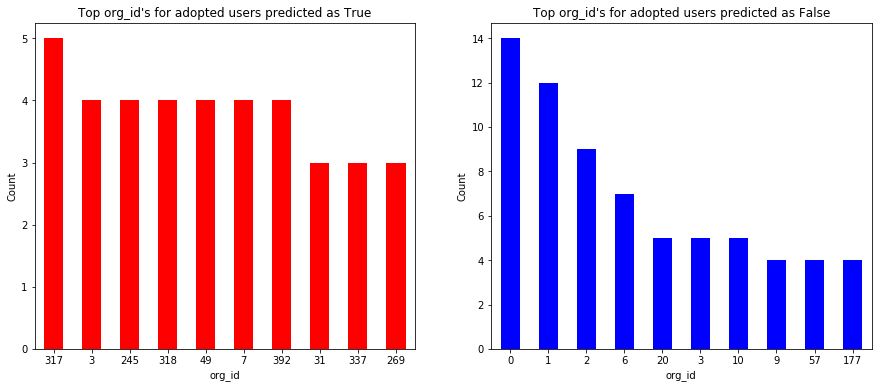

In [154]:
plt.figure(figsize=(15,6))
plt.subplot(122)
final_uncoded_df[final_uncoded_df.adopted_user_predict == False].org_id.value_counts().head(10).plot(kind='bar', rot=0, color='blue')
plt.xlabel('org_id')
plt.ylabel('Count')
plt.title("Top org_id's for adopted users predicted as False")

plt.subplot(121)
final_uncoded_df[final_uncoded_df.adopted_user_predict == True].org_id.value_counts().head(10).plot(kind='bar',rot=0, color='red')
plt.xlabel('org_id')
plt.ylabel('Count')
plt.title("Top org_id's for adopted users predicted as True")
plt.show()

It seems the most common org_id's for the users predicted to not be adopted users far outweigh the most common org_id's for users that were labeled as adopted.

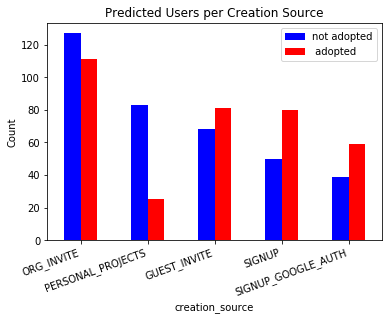

In [125]:
creation_source_df = pd.concat([final_uncoded_df[final_uncoded_df.adopted_user_predict == False].creation_source.value_counts(),
                                final_uncoded_df[final_uncoded_df.adopted_user_predict == True].creation_source.value_counts()], 
                               axis=1, 
                               sort=False)
creation_source_df.columns = ['not adopted', ' adopted']

creation_source_df.plot(kind='bar', color=['blue', 'red'], rot=20)
plt.xticks(ha='right')
plt.ylabel('Count')
plt.xlabel('creation_source')
plt.title('Predicted Users per Creation Source')
plt.show()

Non-adopted users are the most common amongst those in the "personal projects" **creation_source**.  Adopted users are much more common withing hte "GUEST_INVITE", "SIGNUP" AND "SIGNUP_GOOGLE_AUTH" groups.

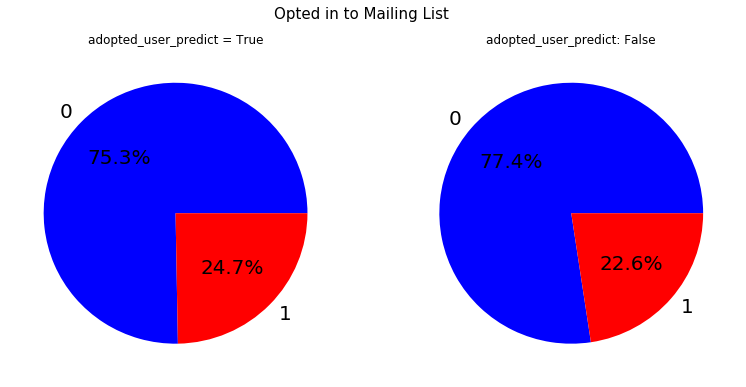

In [155]:
plt.figure(figsize=(13,6))
plt.subplot(122)
final_uncoded_df[final_uncoded_df.adopted_user_predict == False].opted_in_to_mailing_list.value_counts().plot.pie(colors=['blue', 'red'], 
                                                                                                                  autopct='%1.1f%%', 
                                                                                                                  textprops={'fontsize': 20})

plt.ylabel('')
plt.title('adopted_user_predict: False')

plt.subplot(121)
final_uncoded_df[final_uncoded_df.adopted_user_predict == True].opted_in_to_mailing_list.value_counts().plot.pie(colors=['blue', 'red'],
                                                                                                                 autopct='%1.1f%%', 
                                                                                                                 textprops={'fontsize': 20})
plt.ylabel('')
plt.title('adopted_user_predict = True')
plt.suptitle('Opted in to Mailing List', fontsize=15)
plt.show()

Whether or not a user opted in to the mailing list seems to matter little regarding their likelihood to be retained.  A similiar trend is seen with the **enabled_for_marketing_drip** feature.